# 15-13. 프로젝트
# This is your playground! 
# Leaderboard를 정복해 주세요!


-----------------------------------
## 다양한 하이퍼 파라미터를 튜닝하며 최적의 조합 찾기
    - 데이터 정제하기:  EDA 과정을 통해 불필요한 피처 골라내기 혹은 수정하기
    -  튜닝해 볼 수 있는 모델 클래스 인자
        * max_depth : 의사 결정 나무의 깊이, 정수 사용
        * learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터
            , 보통 0.0001~0.1 사이의 실수 사용
        * n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
        * num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
        * boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력
        * 이외에도 lightgbm, xgboost 하이퍼 파라미터 튜닝 키워드검색
            -> 다양한 하이퍼 파라미터의 종류를 확인 가능
        *my_GridSearch(), save_submission() 등의 함수를 사용해도 되고
        , 원하는 새로운 함수를 만들어서 사용가능
        
 ------------------------------------------
 
     - 시도해볼수 있는 방법
         *기존에 있는 데이터의 피처를 모델을 보다 
             잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
         *LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의
          다양한 모델에 대해 하이퍼 파라미터 튜닝하기
         *다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
         * Baseline 커널에서 활용했던 블렌딩 방법 활용하기
         
### 제출한 노트북에는 본인의 캐글 Submission 스코어를 기재

------------------------------------------------------------

## 프로젝트 루브릭

1. 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?


2. 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?


3. 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?


--------------------------

## 평가기준

1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?
:데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다

2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?
:제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
:다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### 코드분석
#### 1)import warnings
     : 버선 샹향에 따라 변경될 수 있음을 알리는 경고 메세지를 키고 끄는 라이브러리
        - 메세지 OFF : warnings.filterwarnings("ignore")
        - 메세지 ON  : warnings.filterwarnings("default")
        
#### 2) os.path.join 
       : 경로명 조작에 관한 처리를 모아둔 모듈로 구현되어 있는 함수
       - 인수에 전달된 2개의 문자열을 결합 => 1개의 경로로 사용함 
       
#### 3) missingno  
       : 결측 데이터들을 파악하는데 직관적인 도움을 주는 패키지
       - 자수 사용하는 그래프
           1. Matrix (매트릭스 형태로 차트 시각화)
            : msno.matrix(df=데이터변수명.iloc[:, :], color=(선의 R값, G값, B값))
           2. Bar Chart (바 형태로 차트 시각화)
            : msno.bar(df=데이터 변수명.iloc[:, :], color=(0.1, 0.6, 0.8))
            
#### 4) from sklearn.ensemble import GradientBoostingRegressor
       ->GradientBoostingRegressor (회귀를 위한 모델)
         : 앙상블 이전가지의 오차를 보정하도록 예측기를 순차적으로 추가하지만 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴
             - 매개변수 (default=’ls’)
             - loss: 최적화할 손실함수를 선택하는 것
                 *'ls' : 최소 제곱(Least Square) 회귀를 나타냄
                 *'lad'(최소 절대 편차): 입력 변수의 순서 정보만을 기반으로하는 매우 강력한 손실 함수
                 *'huber': ls &lad 의 조합
                 *'quantile': 분위수 회귀 허용
                 (default=’ls’)

            - learning_rate: 각 트리의 기여도를 나타냄 (default=0.1)
            - n_estimators: 부스팅 단계의 수를 나타냄 (default=100)
            - subsample: 샘플비율을 나타냄 (default=1.0)
                         (1보다 작으면 확률적 그라데이션 부스팅 발생) 
            - criterion: 분할하는 기준을 선택함 (default=friedman_mse)
                * 종류: 'friedman_mse', 'mse', 'mae'
                * defalut값인 friedman_mse의 기능이 가장 좋음
                
#### 5) from sklearn.model_selection import KFold, cross_val_score
    
        -cross_val_scre (교차검증)
            * 데스트 세트에 각 샘플이 정확히 한번씩 들어가 각 샘플은 하나의 폴드에 속하게 되며 각 폴드는 한번씩 테스트 세트가 됨
            * 교차검증의 점수를 높이기 위해서는 데이터 셋에 모든 샘플에 대해 모델이 잘 일반화 되어야함
            * 모델이 훈련 데이터에 얼마나 민감한지 알수 있음
            * 최악의 경우와 최선의 경우를 짐작가능
            * 주요 단점 = 연산 비용과 시간이 많이듬
            
       - kFold 교차검증
         : k개의 데이터 셋을 만든후 K번 만큼 학습하고 검증을 수행하는 방법
          * 분할 파라미터 설정
          kfold = KFold(n_splits=20, shuffle=True)
              @  n_splits : 데이터 분할 수(전체 데이터 수를 넘을 수 없음)
              @  shuffle : 데이터를 분할전 매번 데이터를 섞을지 말지 여부를 나타냄
         cross_val_score가 받는 파라미터
              1. 모델
              2. feature
              3. target
              4. cv (분할 설정값)
              5. scoring (평가방법)
              
#### 6) XGBoost(eXtra Gradient Boost)
        - 트리 기반 알고리즘의 앙상블 학습 알고리즘
        - GBM의 단점인 느린 수행시간, 과적합 규제 등을 해결
    
#### 7) lightgbm (Light GBM : LGBM)
        - 트리 기반의 학습 알고리즘인 gradient boosting방식의 프레임 위크
        - 나무를 수직으로 확장 & delta loss가 증가하도록 잎의 개수를 정함
        - 데이터 크기가 작은 경우 과적합되기 쉬움으로 max_depth를 줄여줘야함
#### 8) seaborn
        - 데이터 시각화
        - 데이터 형태별 어떤 종류의 그래프가 좋은가?
            * 1차원 데이터 + 실수값, 실수 분포 플롯
                @ 커너밀도, 러그, rugplot, kdeplot, distplot
            * 카테고리별 데이터 양 확인
                @ countplot
            * 다차원 데이터 (변수가 여러 개)
                @ 2차원 실수형 데이터 : 스캐터 플롯(jointplot)
                @ 3차원 이상의 실수형 데이터 : pairplot(그리드 형태로 출력)
                @ 카테고리형 포함시 hue 속성 활용
                @ 2차원 카테고리형 데이터 : heatmap
       
       
#### 참고
    1)https://yganalyst.github.io/etc/memo_15/
    2)https://engineer-mole.tistory.com/188        
    3)https://hong-yp-ml-records.tistory.com/14 
    4)https://biology-statistics-programming.tistory.com/49 
    5) KFold교차검증) https://velog.io/@skyepodium/K-Fold-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D
    6)https://injo.tistory.com/44
    7)https://greatjoy.tistory.com/72
    8)https://chancoding.tistory.com/12
    
---
### 데이터 경로 지정하기 & 데이터 불러오기


In [2]:
data_dir = os.getenv('HOME')+'/aiffel/ex5/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 전처리 하기

In [3]:

## train데이터 전처리
# data 길이 줄이기
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

# pice 저장 및 삭제 & id 삭제
#train 데이터
y = train['price']
del train['price']
del train['id']


## test 데이터 전처리

# test 데이터 전처리 => test데이터는 price값이 없음 => 우리가 예측해야하는 값
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']


print(train.columns)
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [4]:
# fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# # id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
# count = 1
# columns = train.columns
# for row in range(9):
#     for col in range(2):
#         sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(columns[count], fontsize=15)
#         count += 1
#         if count == 19 :
#             break

#### apply(). astype()
    -apply()
         인수로 행/열을 받는 함수를 apply 메서드의 인수로 넣으면 각 열(행)을 반복하여 그 함수에 적용시킴
    -.astype(dtype)
     : Pandas Series를 지정된dtype으로 변환함
     
     
     
#### 참고
1.https://datascienceschool.net/01%20python/04.04%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%EC%9D%98%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%A1%B0%EC%9E%91.html

2.https://www.delftstack.com/ko/howto/python-pandas/how-to-convert-pandas-dataframe-column-to-string/
     

## 타겟 데이터 확인하기
y 데이터 분포도 확인

#### 분포도를 확인하는 이유
데이터의 분포가 너무 치우친 컬럼의 경우 모델 결과를 예측하는데 좋지 않은 영향을 미침기 때문에 데이트의 분포를 확인하고 전처리 하기 위해서 사용


0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


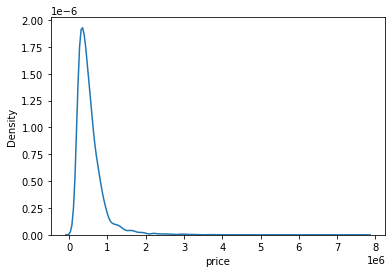

In [5]:
# 타겟 데이터 y확인하기
print(y)

#가격데이터 분포도 확인하기
sns.kdeplot(y)
plt.show()

# 왼쪽으로 그래프가 치우쳐 있는 상태

#### kdeplot()
    : 막대 그래프로는 데이터의 분포를 확인하는 것이 어려움
    -> 커널 민도 추정(KDE: Kernel Density Estimator) 
        : 데이터의 분포를 확인 시켜줌

## 로그 함수로 변환하기
    - np.loglp() : 로그 함수로 변환
    - np.sxpm1() : 되돌리기 (각 원소 x마다 exp(x)-1의 값 반환)
 
 -----------
 #### +) 로그 변환이 분포의 치우침을 줄어들게 하는 이유
     <로그함수의 특징>
        - 0<x<1 범위에서는 기울기가 매우 가파르다
            *x의 구간은 (0, 1)(0,1)로 매우 짧음
            *y의 구간은 (-\infty, 0)(−∞,0)으로 매우 큼
        - 0에 가깝게 모여있는 값들이 x로 입력되면,함수값 y들은 매우 큰 범위로 벌어짐
            * 로그 함수 0에 가까운 값들이 조밀하게 모여있는 입력값을 넓은 범위로 펼칠수 있게 해줌
        -  x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아짐
            * x값들에 대해서는 yy값이 크게 차이나지 않게 됨
            * 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 하는 특징

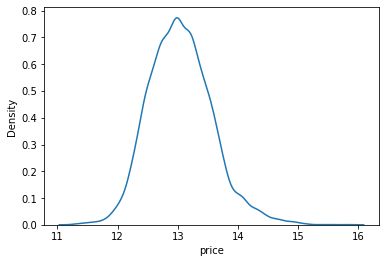

In [6]:
# 로그 변환및 그래프 출력
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 모델 튜닝 시작
    1) RMSE 계산하기 
     :expm1으로 다시 변환 후 mean_squared_error 계산 값에 np.sqrt를 취해서 계산 한다.
     
    2) 모델 가져오기
        - XGBRegressor
        - LGBMRegressor
        - GradientBoostingRegressor
        - RandomForestRegressor
    3) 모델 리스트에 생성한 모델 이스턴스 넣어주기
    4) 모델별로 학습 및 예측하기

In [8]:
# 함수 import 하기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 모델 가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

#### 1) mean_squared_error
    : RMSE를 사용하기 위한 라이브러리
#### 2)XGBRegressor
    : 약한 분류기를 세트로 묶어서 정확도를 예측하는 기법
    -장점
        * 병렬 처리를 사용하기에 학습과 분류가 빠름
        * 유연성이 좋다. 커스텀 최적화 옵션 제공
        * Greedy-algorithm을 사용한 자동 가지치기 가능 (과적합이 잘 발생하지 않음)
        * 다른 알고리즘과 연계하여 앙상블 학습 가능
---------

## RMSE(Root Mean Square Error: 평균제곱근 오차)값 얻기
    - 오차가 음수 있수 일수도 있으니 곱한후 합을 더해 평균을 구함
    - 오차를 최소화하는 최적선을 그리기 위해 사용됨
    - 에러에 제곱을 함으로 에러가 클수록 가중치가 높이 반영됨
    - 에러에 따른 손실이 기하 급수적으로 올라가는 상황에서 쓰기 적합
    - expm1으로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있음
        @np.sqrt : 제곱근을 구해줌

### 참고
1)https://mizykk.tistory.com/102
2)https://riverzayden.tistory.com/17

RMSE)https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=owl6615&logNo=221537580561

In [9]:
# RMSE 계산하기
def rmse(y_test, y_pred):
    # expm1를 사용해 지수로 다시 변환후 RMSE를 구해서 다시 반환
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

모델 추가하기

In [10]:
# model리스트에 생성한 모델 이스턴스 넣어주기
random_state=2020       

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
lasso = LassoCV(random_state=random_state)


models = [gboost, xgboost, lightgbm, rdforest,lasso ]

In [11]:
# 모델별로 학습 및 예측하기

def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
LassoCV,246800.981435
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


#### .sort_values()
: 값을 기준으로 레이블을 정렬하는 메서드

-사용법
    
    df.sort_values(by, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
    
    * by : 정렬 기준이될 레이블
    * axis : {0 : index(행 기준) / 1: columns(열 기준)} 정렬할 기준 레이블
    * inplace : 원본을 대체할지 여부( True일 경우 원본 대체)
    * kind : 알고리즘 모드( quicksort, mergesort, heapsort, stable)
    * na_position : {first / last} Na값의 위치
    * ignore_index : 인덱스 무시 여부(True일 경우 인덱스의 순서와 상관없이 0,1,2,... 로 정해짐)
    * ascending=False :내림차순으로 정렬(디폴드 :ascending (오름차순 정렬))
        
#### 참고
1. https://wikidocs.net/153307
2. https://stackoverflow.com/questions/50996395/pandas-dataframe-sort-values-set-default-ascending-false
    

In [12]:
get_scores(models,train, y)

,RMSE
LassoCV,246800.981435
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


## 하이터 파라미터

    :모델이 학습을 하기 위해서 사전에 사람이 직접 입력해 주는 파라미터
     모델이 학습하는 과정에서 변하지 않음
    : 예시) 학습 횟수에 해당하는 epoch 수, 가중치를 업데이트할 수 있음 
      학습률(learning rate), 또는 선형 규제를 담당하는 labmda 값 등이 이에 해당
      
## 하이퍼 파라미터 조합방법

### 1) 그리드 탐색(grid search)

    -방법) 사람이 먼저 탐색할 하이퍼 파라미터 값들을 정해둠 
            => 그 값들로 만들어질 수 있는 모든 조합 탐색
     - 값에 대한 하아퍼 파라미터 조합을 모두 탐색하고자 할때 유리
     - 탐색하는 공강이 매우 제한적
     - 단점) 정해둔 값들로 이루어지는 조합만 탐색함으로 최적의 조합을 놓칠수 있음
     
### 2) 랜덤 탐색(random search)
    
    -방법 ) 사람이 탐색할 하이퍼 파라미터의 공간만 정해둠
              => 그 안에서 랜덤으로 조합을 선택하여 탐색하는 방법
    - 최적의 조합을 찾을수 있는 가능성이 열려있음
    - 탐색하는 공간이 훨씬 넓음
    - 단점) 최적의 조합을 찾을 가능성이 랜덤성에 의존함으로 
            언제나 최적을 찾을수 있다는 보장이 없음
            
            
 --------------------------------------------
 
 ## GridSearchCV 활용하기
 : 다양한 파라미터를 입력하면 가능한 모든 조합을 탑색해봄
    
    - GridSearchCV에 입력되는 인자들
         * param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
         * scoring : 모델의 성능을 평가할 지표
         * cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
         * verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 
             (숫자가 클수록 더 많은 메세지를 출력합니다.)
         * n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수
         * cv_results_ :결과과 저장됨

In [13]:
# 흐름 파악하기
from sklearn.model_selection import GridSearchCV

In [14]:
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [1, 10],
# }

# # 모델 준비하기 모델은 LightGBM(lgbm)를 사용
# model = LGBMRegressor(random_state=random_state)

# # 모델 초기화 및 모델 학습
# #neg_mean_squared_erro:MSE에 음수를 취한 값인 
# grid_model = GridSearchCV(model, param_grid=param_grid, \
#                         scoring='neg_mean_squared_error', \
#                         cv=5, verbose=1, n_jobs=5)

# grid_model.fit(train, y)
# grid_model.cv_results_

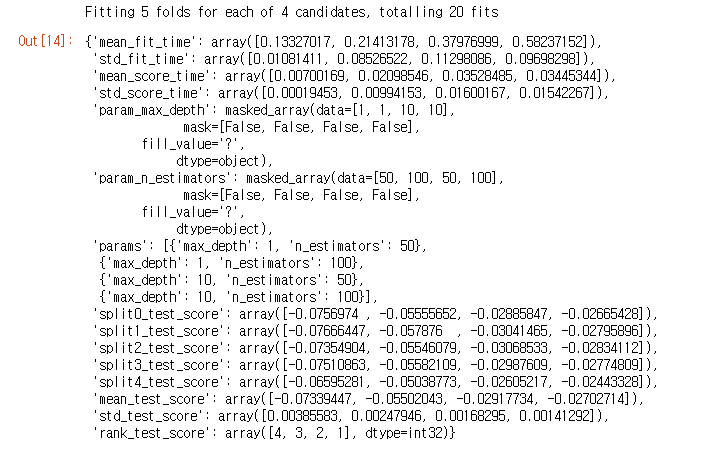

In [15]:
# params = grid_model.cv_results_['params']
# score = grid_model.cv_results_['mean_test_score']
# results = pd.DataFrame(params)
# results['score'] = score

# results

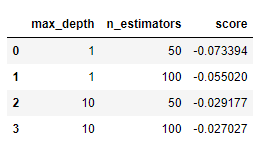

 ### 양수로 바꿔주기 & 루트 연산하기& 낮은 순으로 정렬하기
 

In [16]:
# results['RMSE'] = np.sqrt(-1 * results['score'])
# results = results.rename(columns={'RMSE': 'RMSLE'})
# results

# # 낮은 순이로 정렬하기
# results = results.sort_values('RMSLE')
# results

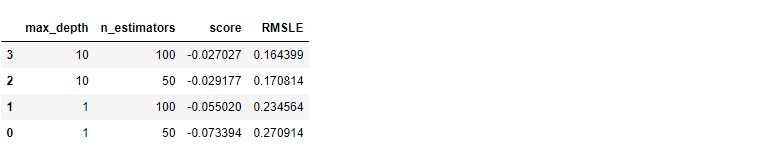

--------

다양한 하이퍼 파라미터에 대한 그리드 탐색 시도해 최적의 조합찾기

### GridSearchCV() 함수 만들기 

In [17]:
# 그리드 탐색하기
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [18]:
#튜닝해볼 수 있는 모델 클래스 인자 사용하기
# 그리드 탐색하기
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate':[0.001],
     'num_leaves' :[90]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

#'learning_rate 를 줄일수록 오차가 더 커졌다.
#'num_leaves' :[90]일때 오차가 아주 살짝 작아짐

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
3,0.001,10,100,90,-0.237043,0.486871
2,0.001,10,50,90,-0.256786,0.506741
1,0.001,1,100,90,-0.262146,0.512002
0,0.001,1,50,90,-0.270001,0.519616


파라미터 튜닝 :

데이터 사이언티스트는 언제나 어떤 파라미터를 언제 사용할지 그리고 어떤 값이 최적의 파라미터 값일지 결정하기 위해 고민합니다.

아래 소개되는 기법들은 모델 정확도를 향상시키기 위해 사용될 수 있습니다.

num_leaves : Tree 모델의 복잡성을 컨트롤하는 주요 파라미터입니다. 이상적으로 num_leaves 값은 2 ^ (max_depth) 값보다 적거나 같아야 합니다. 이것보다 많은 값은 과적합을 유발할 것입니다.
min_data_in_leaf : 큰 값으로 세팅하는 것은 Tree가 너무 깊게 확장되는 것을 막을 수 있지만 under-fitting 언더 피팅이 발생할 수도 있습니다. 관행적으로, 수백 또는 수천 개로 정하는 것이 큰 데이터 세트에 충분합니다.
max_depth : Tree 깊이를 명확하게 제한하기 위해 max_depth 값을 설정할 수도 있습니다.

https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning
https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=pgh7092&logNo=221091720350

## 하이퍼파라미터 튜닝하기

#### (1) Booster Method
        - 부스팅 방법을 결정하는 파라미터로 모형, 성능, 학습 시간, 램 사용량이 영향을 줌
        - * 사용법을 잘 모르겠으면 디폴트(GBDT) 설정대로 사용
            -> DART: 과적합을 제어 가능
#### (2) Tree Building Method
        - 트리를 만드는 방법을 설정하는 파라미터( xgboost에만 존재)
        - 모델 성능과 학습시간에 영향을 준다
            =  Exact method('exact'): 정확한 학습
            = Approximate method('approx', 'hist', 'gpu_hist'): 학습속도 높이기
        - 데이터 행수가 10만 단위를 넘어가면 xgboost에서 'gpu_hist' 사용하는게 좋음
        - 데이터 행수가 적으면 정확도를 위해  'exact'사용
        - 데이터 행수가 많은데 gpu를 사용할 수 없다면 'hist', gpu를 사용
#### (3) Learning rate
        -부스팅 각 이터레이션 마다 곱해지는 가중치(loss function의 step size)
        -모형 성능과 학습시간에 영향을 준다
        -작을수록 모형 성능 향상에 도움이 되지만 학습 시간은 길어지는 trade-off가 있음
#### (4) Number of Iterations
        -부스팅 이터레이션 수
        -모델 성능과 학습시간, 램 사용량에 영향을 줌
        -클수록 train 데이터에 오버피팅 됨
        -early stopping 없이 이터레이션 수의 값을 크게 넣으면 학습데이터에 오버피팅됨
#### (5) Maximum Depth
        -각 트리의 최대 깊이
        -최대 리프 수(Maximum Leaves), 모형 성능, 학습 시간에 영향을 줌
        -값이 크면 학습 데이터에 피팅은 잘 되지만 오버피팅될 가능성도 높아짐
        -보통 3-12의 값을 사용함
        -가장 먼저 튜닝해야 할 하이퍼파라미터
#### (6) Maximum leaves
    -각 트리의 최대 리프 수
    -트리의 최대 깊이, 모형 성능, 학습속도에 영향을 미침
    -Maximum Depth와 함께 튜닝하는 것이 좋음
    -그라디언트 부스팅에서 두번째로 민감한 하이퍼파라미터로 Maximum Depth와 함께 튜닝해주는 것이 좋음
    -Maximum Depth를 크게 설정 > Maximum Leaves를 조절하면 규제로 작용 => 트리가 너무 거대해지는 것 방지
#### (7) Row Sampling
    -각 이터레이션에 사용되는 행의 비율
    -Early Stopping, 모형 성능, 학습시간에 영향을 미침
    - 보통 0.7 정도의 값을 사용(너무 세세하게 튜닝할 필요 없음)
    -그라디언트 부스팅에서 세번째로 민감한 하이퍼파라미터로 column sampling과 함께 튜닝하는게 좋음
    -특정 랜덤 시드에서 0.728472 같이 아주 특이한 값을 사용할 때 오버피팅이 발생
#### (8) Column Sampling by Tree
    -각 이터레이션에 사용되는 칼럼의 비율
    -Early Stopping, 모형 성능, 학습시간에 영향을 미친다
    -보통 0.7 정도의 값을 사용
    -그라디언트 부스팅에서 세번째로 민감한 하이퍼파라미터로 row sampling과 함께 튜닝하는것이 좋음
#### (9) Positive Binary Scaling
    -이진분류 문제(label: {0, 1})를 풀 때 posivite label(label: 1)에 가중치를 부여하는 것. 
    -모형 성능과 학습시간에 영향을 줌
    -모르겠으면 디폴트 값 사용 추천
    -cale_pos_weight를 조절해주는 것 보다는 이 값은 디폴트로 두고, 언더샘플링 같이 데이터셋에 대한 샘플링 기법을 적용하는 것이 더 효과적

참고:https://psystat.tistory.com/131

## submission.csv 파일을 만들어서 제출
    1. 해당 파라미터로 구성된 모델 준비 & 학습 & 결과 생성

In [19]:
odel = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)

#원래 스케일로 되돌리기
prediction = np.expm1(prediction)

#sample_submission.csv 파일을 가져오기

data_dir = os.getenv('HOME')+'/aiffel/ex5/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

# 데이터 프레임에 우리 모델이 예측한 값 덮어씌우기
submission['price'] = prediction
submission.head()

#데이터를 csv 파일로 
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/ex5/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [20]:

"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    # 원래스케일로 되돌리기
    prediction = model.predict(test)
    #예측하기
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/ex5/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [21]:
# 함수 사용해서 저장하기
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/ex5/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!
[CV] END learning_rate=0.001, max_depth=1, n_estimators=50, num_leaves=90; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=100, num_leaves=90; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=100, num_leaves=90; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=10, n_estimators=50, num_leaves=90; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=10, n_estimators=100, num_leaves=90; total time=   1.1s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=50, num_leaves=90; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=100, num_leaves=90; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=10, n_estimators=50, num_leaves=90; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=10, n_estimators=50, num_leaves=90; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=10, n_estimators=100, 

# 회고
EX5번을 진행하면서 가장 큰 문제는 뭔말인지 모르겠다 였다. 그러다 보니 목표에 도달하기 위해서 뭘 어떻게 바꾸고 왜 바꿔야하며 무슨 결과가 나온건지 몰랐다. 그래서 나는 코드를 하나하나 조사하고 주석을 달아 하나의 코드가 무엇을 의미하고 수행하는지를 조사하는 것을 첫걸음으로 하였다. 그 후에는 아래와 같이 각 변수가 어떤 기능하고 어떤 데이터를 저장하는지를 파악하여 코드의 전체적인 흐름을 조사하였다.
그 후에 다시 목표를 읽어보고 무엇을 추가하고 변경해야하지는지를 조사해보았다.
하이퍼파라미터도 변경해 보고 모델을 추가해 봤지만 num_leaves를 하여 loss가 감소한것 외에는 별다른 변화가 없었다.
사실 하이퍼파라미터는 다른 것들을 추가해보기도하고 조사도 해보았는데 어떻게 적용해야하는지가 감이 안잡혀서 제대로 사용해 보지 못한것같아 아쉬웠다.
그러나 처음 시작할때 목표였던 구조를 이해하고 왜 이코드가 사용되는지를 알수 있었기에 만족한다.

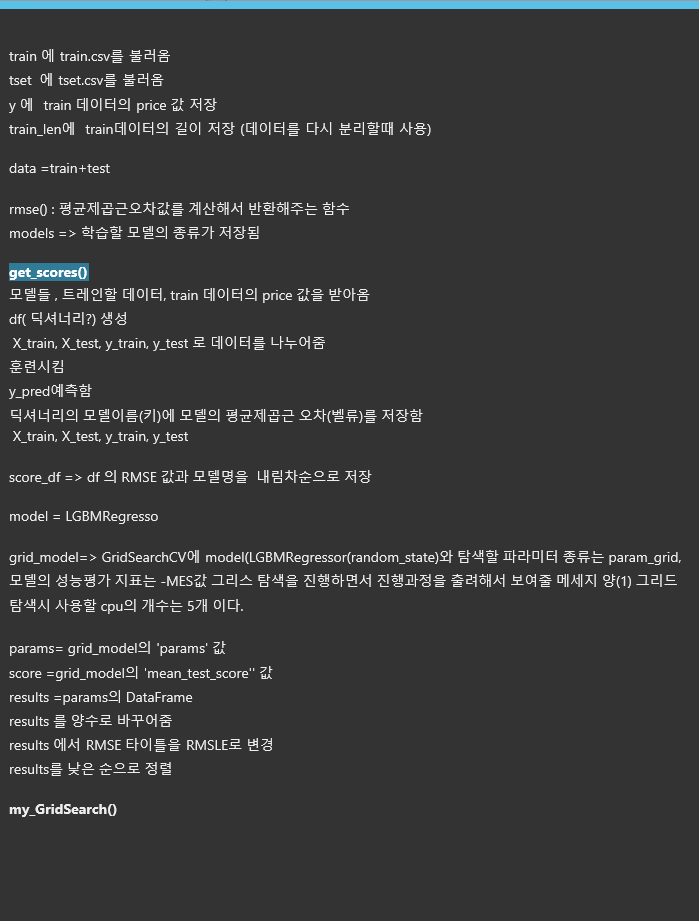

수행목록
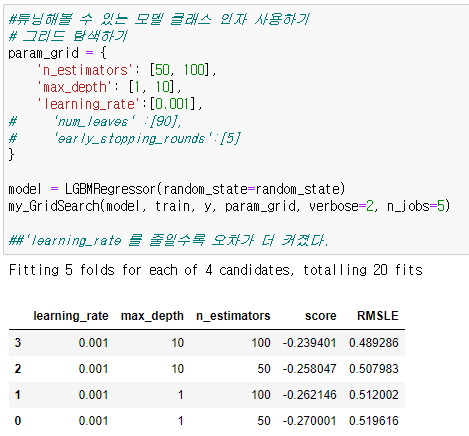
하이퍼파라미터 튜닝
=> 결과 :'num_leaves' :[90]
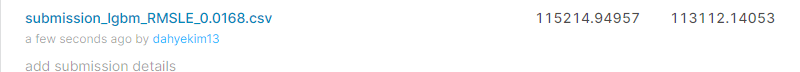